In [114]:
!pip install pandas

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [115]:
!pip install statsmodels

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [116]:
!pip install sklearn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [117]:
import pandas as pd
import numpy as np
import datetime
import copy
import math
from statsmodels.tsa.stattools import adfuller
import  matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
import pickle
from sklearn.metrics import r2_score

In [118]:
df=pd.read_csv(r'autodl-nas/data_clean.csv')

In [119]:
df_copy=copy.deepcopy(df)

In [120]:
df

,Unnamed: 0,Invoice/Item Number,Date,Store Number,Store Name,City,County,Category Name,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),location
0,0,s24127700024,2015-02-19,3678,"smoke shop, the",des moines,polk,vodka flavored,phillips beverage company,41783,uv blue raspberry vodka mini,6,500,4.89,7.34,2.0,14.68,1.00,0.26,-93.597011 41.570844
1,1,s15066200002,2013-10-10,2633,hy-vee,des moines,polk,misc. imported cordials & liqueurs,mhw ltd,904969,sabe premiom sake double barrel,6,750,14.99,22.48,6.0,135.00,4.50,1.19,-93.596754 41.554101
2,2,s19323500030,2014-06-03,2607,hy-vee wine and spirits,shenandoah,page,puerto rico & virgin islands rum,luxco-st louis,45277,paramount white rum,12,1000,4.34,6.51,12.0,78.10,12.00,3.17,-95.385111 40.761736
3,3,s23334500013,2015-01-06,4810,kum & go,ankeny,polk,puerto rico & virgin islands rum,"bacardi u.s.a., inc.",43121,bacardi superior rum mini,12,500,5.54,8.31,1.0,8.31,0.50,0.13,-93.572458 41.760989
4,4,s09742200010,2012-12-27,4025,karam kaur khasriya llc,belle plaine,benton,canadian whiskies,diageo americas,11298,crown royal canadian whisky,6,1750,31.00,46.50,2.0,93.00,3.50,0.92,-92.277759 41.897052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19480372,19480372,s10600200004,2013-02-13,3864,hometown foods,schaller,sac,american cocktails,"sazerac co., inc.",59231,ice box mudslide,6,1750,5.75,9.13,6.0,54.78,10.50,2.77,-95.29346 42.499481
19480373,19480373,s23597800012,2015-01-21,5065,circle s gordon drive,sioux city,woodbury,whiskey liqueur,"sazerac co., inc.",64863,fireball cinnamon whiskey,48,200,3.33,5.00,4.0,20.00,0.80,0.21,-96.376341 42.489845
19480374,19480374,s29278700041,2015-11-24,3400,last stop beverage shop,des moines,polk,vodka 80 proof,phillips beverage company,37336,uv vodka,12,750,6.50,9.75,12.0,117.00,9.00,2.38,-93.561517 41.600476
19480375,19480375,s04908000004,2012-04-05,2579,hy-vee food store,grinnell,poweshiek,puerto rico & virgin islands rum,"bacardi u.s.a., inc.",43128,bacardi superior rum,6,1750,14.67,22.00,6.0,132.00,10.50,2.77,-92.727343 41.7283


<font size=5>首先明确我们需要预测的是要以月为单位的sale  因而需要先把日期格式改成year-month 的格式再进行分组排序操作

In [121]:
# print(datetime.datetime.strptime(df['Date'][0],'%Y-%m-%d'))

In [122]:
# a=datetime.datetime.strptime(df['Date'][0],'%Y-%m-%d')

In [123]:
%%time
df['Date']=df['Date'].map(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d'))

CPU times: user 2min 31s, sys: 3.29 s, total: 2min 34s
Wall time: 2min 34s


In [124]:
df['year_month']=df['Date'].map(lambda x:datetime.datetime.strftime(x,'%Y-%m'))

<font size=5>生成分组数据集  保存到sales

In [125]:
sales=df.groupby(['County','year_month'])['Sale (Dollars)'].sum()

In [126]:
sales

County  year_month
adair   2012-01       24965.97
        2012-02       28078.03
        2012-03       25379.89
        2012-04       36606.81
        2012-05       35783.13
                        ...   
wright  2020-05       71600.37
        2020-06       81208.40
        2020-07       70382.92
        2020-08       78304.91
        2020-09       84895.10
Name: Sale (Dollars), Length: 10382, dtype: float64

<font size=5>再次明确需要预测的目标county:  polk linn scott

<AxesSubplot:xlabel='year_month'>

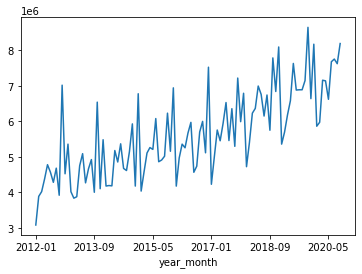

In [127]:
## 数据集具有明显的趋势性  需要对数据集进行处理  使其具有平稳性

sales['polk'].plot(kind='line')

<AxesSubplot:xlabel='year_month'>

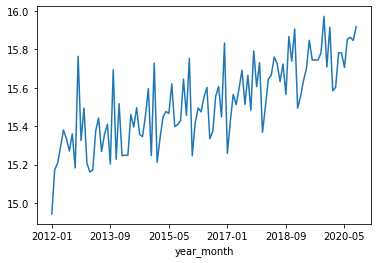

In [128]:
## 对数据取对数  观察平稳性情况

sales['polk'].map(np.log).plot(kind='line')

<AxesSubplot:xlabel='year_month'>

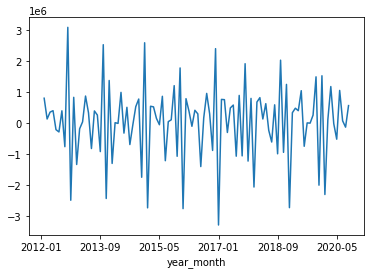

In [129]:
## 对数据做一阶差分  观察平稳性情况  发现其平稳性具有明星好转

sales['polk'].diff(1).plot(kind='line')

<AxesSubplot:xlabel='year_month'>

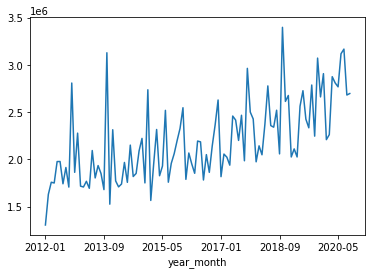

In [130]:
sales['linn'].plot(kind='line')

<AxesSubplot:xlabel='year_month'>

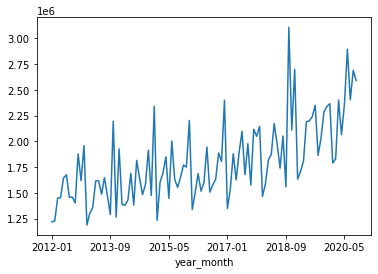

In [131]:
sales['scott'].plot(kind='line')

<font size=7>建模

# ARIMA

In [132]:
polk=pd.DataFrame({'sale':sales['polk'].values},index=sales['polk'].index)

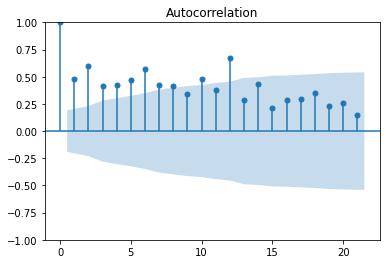

In [133]:
## acf判断


from statsmodels.graphics.tsaplots import plot_acf
 
plot_acf(polk).show()


##  自相关图并不是拖尾也不是截尾   说明原数据不具有稳定性

### 平稳性检测

In [134]:

# 1 平稳性检测
 
from statsmodels.tsa.stattools import adfuller as ADF
 
 
def tagADF(t):
    result = pd.DataFrame(index=[
            "Test Statistic Value", "p-value", "Lags Used", 
            "Number of Observations Used", 
            "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)"
        ], columns=['sale']
    );
    result['sale']['Test Statistic Value'] = t[0]
    result['sale']['p-value'] = t[1]
    result['sale']['Lags Used'] = t[2]
    result['sale']['Number of Observations Used'] = t[3]
    result['sale']['Critical Value(1%)'] = t[4]['1%']
    result['sale']['Critical Value(5%)'] = t[4]['5%']
    result['sale']['Critical Value(10%)'] = t[4]['10%']
    return result;


In [135]:
print('原始序列的ADF检验结果为:',tagADF(ADF(polk['sale'])))

原始序列的ADF检验结果为:                                  sale
Test Statistic Value         2.739628
p-value                      0.999088
Lags Used                          13
Number of Observations Used        91
Critical Value(1%)          -3.504343
Critical Value(5%)          -2.893866
Critical Value(10%)         -2.584015



### 平稳判断：得到统计量大于三个置信度(1%,5%,10%)临界统计值，p值显著大于0.05，该序列为非平稳序列。

In [136]:
##  对原数据集进行一阶差分处理   并储存到d_polk中

d_polk = polk.diff(1).dropna()
d_polk.columns = ['d_sale']

<AxesSubplot:xlabel='year_month'>

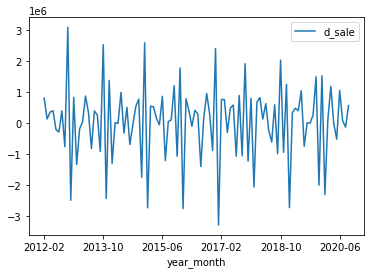

In [137]:
## 差分处理后的分布展示

d_polk.plot()

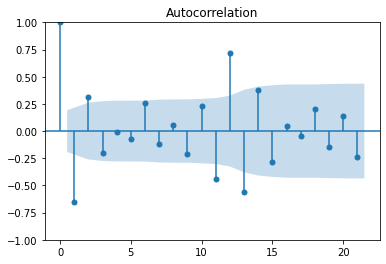

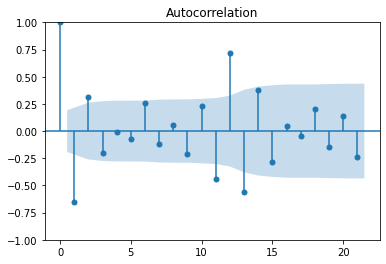

In [138]:
## 差分处理后的自相关


plot_acf(d_polk)

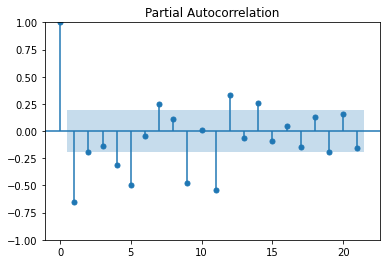

In [139]:
## 差分处理后的偏自相关

from statsmodels.graphics.tsaplots import plot_pacf
 
plot_pacf(d_polk).show()

In [140]:
print('原始序列的ADF检验结果为:',tagADF(ADF(d_polk['d_sale'])))

原始序列的ADF检验结果为:                                  sale
Test Statistic Value        -3.741141
p-value                       0.00357
Lags Used                          13
Number of Observations Used        90
Critical Value(1%)           -3.50519
Critical Value(5%)          -2.894232
Critical Value(10%)          -2.58421


### 经过差分处理后   在5%的置信区间下显著

## 创建train set 以及 test set 备用

In [141]:
len(polk)

105

In [142]:
## 以后6个月作为测试集   前面的月份则为训练集

train_polk=polk[0:99]
test_polk=polk[99:106]

##  p，q定阶

In [143]:
#  p，q定阶
 
from statsmodels.tsa.arima.model import ARIMA
 
#一般阶数不超过length/10
 
pmax = int(len(d_polk)/10) 
 
 
qmax= int(len(d_polk)/10)

In [144]:
#bic矩阵
 
bic_matrix = [] 
for p in range(pmax+1):
  tmp = []
  for q in range(qmax+1):
#存在部分报错，所以用try来跳过报错。
    try: 
      tmp.append(ARIMA(polk, order=(p,1,q)).fit().bic)
    except:
      tmp.append(None)
  bic_matrix.append(tmp)
 
#从中可以找出最小值
 
bic_matrix = pd.DataFrame(bic_matrix) 
 
bic_matrix

,0,1,2,3,4,5,6,7,8,9,10
0,3210.166885,3160.411544,3164.161732,3161.279453,3166.621247,3165.920459,3176.606866,3182.176909,3188.539485,3184.672446,3189.192717
1,3166.318357,3163.011429,3160.486177,3165.955922,3161.388282,3164.173097,3157.127031,3160.805991,3165.538069,3173.839325,3177.283780
2,3168.981044,3164.762773,3174.168640,3164.163095,3155.872506,3168.588180,3163.119230,3165.240970,3169.477926,3178.347831,3174.666361
3,3172.721261,3168.099530,3175.822584,3155.053254,3169.666398,3159.370731,3165.125778,3169.083640,3172.888521,3167.384455,3175.718687
4,3171.568197,3167.655971,3156.240184,3158.534754,3163.799446,3171.846595,3163.170943,3163.122008,3167.956140,3170.971022,3178.722617
5,3160.491651,3164.977556,3158.693007,3157.068812,3161.564505,3172.207945,3166.931014,3176.600273,3167.582235,3172.112809,3176.502137
6,3165.018710,3168.917697,3161.527362,3182.929610,3168.497507,3167.611607,3170.387163,3181.643844,3174.257173,3177.173769,3186.631623
7,3164.621146,3169.034747,3168.436329,3189.920484,3185.674148,3175.268813,3175.947171,3180.192197,3178.622386,3180.766161,3176.715761
8,3168.994810,3174.711493,3165.786989,3179.833619,3224.209728,3179.714346,3173.941852,3172.779426,3169.081714,3173.525913,3175.606319
9,3182.605944,3186.602887,3180.232385,3159.574169,3174.495274,3187.576962,3177.811202,3173.689297,3183.696179,3187.890718,3210.705637


In [145]:
p,q = bic_matrix.stack().idxmin() 

print(u'BIC最小的p值和q值为：%s、%s' %(p,q))



# BIC最小的p值和q值为：3,3

BIC最小的p值和q值为：3、3


In [146]:

model_arima= ARIMA(polk, order=(3,1,3)).fit() 
forecast_polk=model_arima.forecast(15)

In [147]:
# forecast_polk=pd.DataFrame({'sale':forecast_polk})
# forecast_polk=pd.concat([polk,forecast_polk],axis=0)

In [148]:
data_predict=model_arima.predict(1,104)

In [149]:
new_polk=polk[1:105]
new_polk.index=list(data_predict.index)

In [150]:
data_forecast=model_arima.forecast(15)

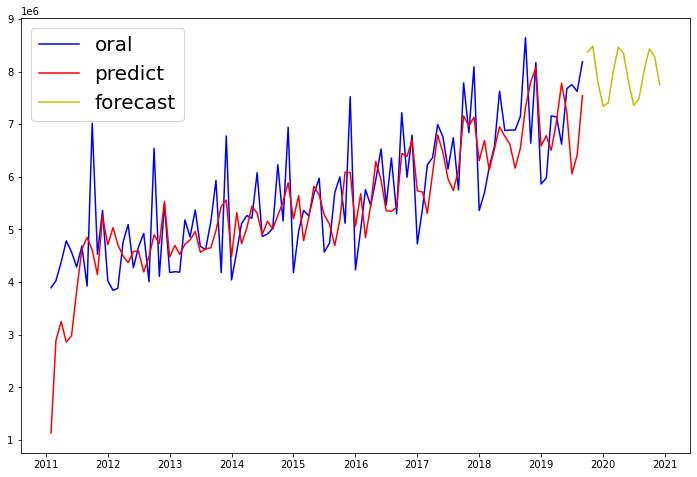

In [151]:
plt.figure(figsize=(12, 8))

x = list(range(len(data_predict)))
x1=list(range(len(data_predict)+15))

oral_line=plt.plot(new_polk, color="b", label="原始数据")

predict_line=plt.plot(data_predict, color='r', label="预测数据")

forecast_line=plt.plot(data_forecast, color='y',label='forecast')
labels=['oral','predict','forecast']

plt.legend(labels, fontsize=20, loc='upper left')

### 这块使用最后的10个月来观察模型的拟合程度   使用mse  msa  以及r2进行衡量评价

In [152]:
predict_10 = data_predict[-11:]
fact_10 = new_polk[-11:]

In [153]:
mse = mean_squared_error(fact_10,predict_10)
mae = mean_absolute_error(fact_10,predict_10)
r2s = r2_score(fact_10,predict_10)
print('MSE: ', mse, '\n', 'MAE: ', mae, '\n', 'R square: ', r2s)


# MSE:  842772226777.4719 
#  MAE:  790399.3286210742 
#  R square:  -0.41404394182537185

## 回归函数拟合效果差于取平均值时R2会为负数

MSE:  842772226777.4719 
 MAE:  790399.3286210742 
 R square:  -0.41404394182537185


In [ ]:
##  保存一下groupby(sales)的文件

# import pickle

# with open('autodl-nas/groupby.pkl', 'wb') as f:
#     pickle.dump(sales, f)


In [ ]:
##   重新载入pickle文件   （groupby）   重新储存为sales

f = open('autodl-nas/groupby.pkl','rb')

sales=pickle.load(f)

In [ ]:
polk=sales['polk']

In [ ]:
d_polk = polk.diff(1).dropna()
d_polk.columns = ['d_sale']

# SARIMA 预测模型

SARIMA模型自回归阶数以及移动阶数 差分阶数直接套用ARIMA模型的调参结果p=3 q=3 d=1  

在SARIMA模型中由于会对周期性规律进行捕捉因而需要加入新的季节性参数   SARIMAX(p, d, q) × (P, D, Q, s)

P, D, Q, s ：
P是SAR项的周期性阶数，比如你的数据的周期是12，与此同时，偏自相关系数在24， 36时呈现出周期性，那么就需要将Q值 取为1， 2
D是季节项差分的阶数。一般是取1。
Q时SMA的周期性阶数，同理Q，只不过这时需要看自相关系数了。
s：代表你的周期是多少。比如我上面说的周期为12，则s=12.

###  对季节性参数定阶  (P, D, Q, s)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
from itertools import product

# 季节项相关的参数
Ps = range(0, 3)
D = range(0,3)
Qs = range(0,3)
# 将参数打包，传入下面的数据，是哦那个BIC准则进行参数选择
params_list = list(product(Ps, D, Qs))


###  此处直接套用ARIMA的参数 （p=3 q=3 d=1）   只对季节性参数定阶

In [154]:
from tqdm import tqdm_notebook
import warnings
# 忽视在模型拟合中遇到的错误
warnings.filterwarnings("ignore")
# 找最优的参数 SARIMAX
def find_best_params(data:np.array, params_list):
    result = []
    best_bic = 100000
    for param in tqdm_notebook(params_list):
        # 模型拟合
        # model = SARIMAX(data,order=(param[0], param[1], param[2]),seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
        model = SARIMAX(data, order=(3,1,3), seasonal_order=(param[0], param[1], param[2], 12)).fit(disp=-1)
        bicc = model.bic # 拟合出模型的BIC值
        # print(bic)
        # 寻找最优的参数
        if bicc < best_bic:
            best_mode = model
            best_bic = bicc
            best_param = param
        param_1 = (param[0], param[1], param[2])
        param = 'SARIMA{}'.format(param_1)
        print(param)
        result.append([param, model.bic])

    result_table = pd.DataFrame(result)
    result_table.columns = ['parameters', 'bic']
    result_table = result_table.sort_values(by='bic',ascending=True).reset_index(drop=True)
    return result_table


In [155]:
result_table = find_best_params(polk, params_list)
print(result_table)


# ##  对于SARIMA模型   最优参数可以确定为   （3,1,3）*（ 0,2,1,12）

  0%|          | 0/27 [00:00<?, ?it/s]

SARIMA(0, 0, 0)
SARIMA(0, 0, 1)
SARIMA(0, 0, 2)
SARIMA(0, 1, 0)
SARIMA(0, 1, 1)
SARIMA(0, 1, 2)
SARIMA(0, 2, 0)
SARIMA(0, 2, 1)
SARIMA(0, 2, 2)
SARIMA(1, 0, 0)
SARIMA(1, 0, 1)
SARIMA(1, 0, 2)
SARIMA(1, 1, 0)
SARIMA(1, 1, 1)
SARIMA(1, 1, 2)
SARIMA(1, 2, 0)
SARIMA(1, 2, 1)
SARIMA(1, 2, 2)
SARIMA(2, 0, 0)
SARIMA(2, 0, 1)
SARIMA(2, 0, 2)
SARIMA(2, 1, 0)
SARIMA(2, 1, 1)
SARIMA(2, 1, 2)
SARIMA(2, 2, 0)
SARIMA(2, 2, 1)
SARIMA(2, 2, 2)
         parameters          bic
0   SARIMA(0, 2, 1)  2389.300782
1   SARIMA(0, 2, 2)  2393.667274
2   SARIMA(1, 2, 1)  2393.675621
3   SARIMA(1, 2, 2)  2397.043898
4   SARIMA(2, 2, 1)  2397.090910
5   SARIMA(2, 2, 2)  2401.069893
6   SARIMA(2, 2, 0)  2404.482890
7   SARIMA(1, 2, 0)  2406.500166
8   SARIMA(0, 2, 0)  2411.949715
9   SARIMA(0, 1, 1)  2722.326958
10  SARIMA(1, 1, 0)  2726.669940
11  SARIMA(2, 1, 0)  2726.879652
12  SARIMA(1, 1, 1)  2728.243105
13  SARIMA(0, 1, 2)  2728.960854
14  SARIMA(1, 1, 2)  2731.340497
15  SARIMA(2, 1, 1)  2732.572530
16  SAR

In [ ]:
model_sarima=SARIMAX(polk, order=(3, 1, 3), seasonal_order=(0, 2, 1, 12)).fit(disp=-1)

In [ ]:
## 以后6个月作为测试集   前面的月份则为训练集

# train_polk=polk[0:99]
# test_polk=polk[99:106]


In [ ]:
data_predict=model_sarima.predict(1,104)

In [ ]:
new_polk=polk[1:105]
new_polk.index=list(data_predict.index)

In [ ]:
##  预测后15个月的销量

data_forecast=model_sarima.forecast(15)


In [ ]:
plt.figure(figsize=(12, 8))

x = list(range(len(data_predict)))
x1=list(range(len(data_predict)+15))

oral_line=plt.plot(new_polk, color="b", label="原始数据")

predict_line=plt.plot(data_predict, color='r', label="预测数据")

forecast_line=plt.plot(data_forecast, color='y',label='forecast')
labels=['oral','predict','forecast']

plt.legend(labels, fontsize=20, loc='upper left')

In [ ]:

##  模型表现

predict_10 = data_predict[-11:]
fact_10 = new_polk[-11:]
mse = mean_squared_error(fact_10,predict_10)
mae = mean_absolute_error(fact_10,predict_10)
r2s = r2_score(fact_10,predict_10)
print('MSE: ', mse, '\n', 'MAE: ', mae, '\n', 'R square: ', r2s)


# MSE:  250870714380.16223 
#  MAE:  411317.88010497706 
#  R square:  0.027284067764996922

# 尝试Holt-winter 季节性预测算法

### Holt-winter 季节性预测算法是一种三指数平滑方法(ExponentialSmoothing)。它包含三个主要部分：水平、趋势、季节性分量。

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

model_ES= ExponentialSmoothing(polk ,trend='add', seasonal='add').fit()

In [ ]:
data_predict=model_ES.predict(1,104)

In [ ]:
data_forecast=model_ES.forecast(15)

In [ ]:
plt.figure(figsize=(12, 8))

x = list(range(len(data_predict)))
x1=list(range(len(data_predict)+15))

oral_line=plt.plot(new_polk, color="b", label="原始数据")

predict_line=plt.plot(data_predict, color='r', label="预测数据")

forecast_line=plt.plot(data_forecast, color='y',label='forecast')
labels=['oral','predict','forecast']

plt.legend(labels, fontsize=20, loc='upper left')

In [ ]:
##  模型表现

predict_10 = data_predict[-11:]
fact_10 = new_polk[-11:]
mse = mean_squared_error(fact_10,predict_10)
mae = mean_absolute_error(fact_10,predict_10)
r2s = r2_score(fact_10,predict_10)
print('MSE: ', mse, '\n', 'MAE: ', mae, '\n', 'R square: ', r2s)


# MSE:  122599535267.92076 
#  MAE:  288590.2857491322 
#  R square:  0.5246375347781773

# conclusion:

对上述的三个模型进行总结：

ARIMA模型表现：

MSE:  294820013948.2467 
MAE:  447701.9826744748 
R square:  -0.14312316372900002

注： 回归函数拟合效果差于取平均值时R2会为负数


SARIMA 模型表现：

MSE:  250870714380.16223 
MAE:  411317.88010497706 
R square:  0.027284067764996922
 
Holt-winter 模型表现：

MSE:  122599535267.92076 
MAE:  288590.2857491322 
R square:  0.5246375347781773

 综上， 在polk为例的case中， holt-winter的表现最佳， 因而我们将把该模型应用于其他的county的预测中

# MODEL APPICATION:

## FOR POLK:

In [ ]:
polk=pd.DataFrame({'sale':sales['polk'].values},index=sales['polk'].index)

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

model_ES_polk= ExponentialSmoothing(polk ,trend='add', seasonal='add').fit()

In [ ]:
data_predict_polk=model_ES_polk.predict(1,104)
data_forecast_polk=model_ES_polk.forecast(15)

new_polk=polk[1:105]
new_polk.index=list(data_predict_polk.index)


In [ ]:
plt.figure(figsize=(12, 8))

x = list(range(len(data_predict_polk)))
x1=list(range(len(data_predict_polk)+15))

oral_line=plt.plot(new_polk, color="b", label="原始数据")

predict_line=plt.plot(data_predict_polk, color='r', label="预测数据")

forecast_line=plt.plot(data_forecast_polk, color='y',label='forecast')
labels=['oral','predict','forecast']

plt.legend(labels, fontsize=20, loc='upper left')

In [ ]:
##  forecast number:
data_forecast_polk

## FOR Linn

In [ ]:
linn=pd.DataFrame({'sale':sales['linn'].values},index=sales['linn'].index)

In [ ]:
model_ES_linn= ExponentialSmoothing(linn ,trend='add', seasonal='add').fit()

In [ ]:
data_predict_linn=model_ES_linn.predict(1,104)
data_forecast_linn=model_ES_linn.forecast(15)

new_linn=linn[1:105]
new_linn.index=list(data_predict_linn.index)

In [ ]:
plt.figure(figsize=(12, 8))

x = list(range(len(data_predict_linn)))
x1=list(range(len(data_predict_linn)+15))

oral_line=plt.plot(new_linn, color="b", label="原始数据")

predict_line=plt.plot(data_predict_linn, color='r', label="预测数据")

forecast_line=plt.plot(data_forecast_linn, color='y',label='forecast')
labels=['oral','predict','forecast']

plt.legend(labels, fontsize=20, loc='upper left')

In [ ]:
##  forecast number:
data_forecast_linn

## FOR scott

In [ ]:
scott=pd.DataFrame({'sale':sales['scott'].values},index=sales['scott'].index)

In [ ]:
model_ES_scott= ExponentialSmoothing(scott ,trend='add', seasonal='add').fit()

In [ ]:
data_predict_scott=model_ES_scott.predict(1,104)
data_forecast_scott=model_ES_scott.forecast(15)

new_scott=scott[1:105]
new_scott.index=list(data_predict_scott.index)

In [ ]:
plt.figure(figsize=(12, 8))

x = list(range(len(data_predict_scott)))
x1=list(range(len(data_predict_scott)+15))

oral_line=plt.plot(new_scott, color="b", label="原始数据")

predict_line=plt.plot(data_predict_scott, color='r', label="预测数据")

forecast_line=plt.plot(data_forecast_scott, color='y',label='forecast')
labels=['oral','predict','forecast']

plt.legend(labels, fontsize=20, loc='upper left')

In [ ]:
##  forecast number:
data_forecast_scott